In [1]:
import glob
from decouple import config
import os
import pandas as pd
import nilearn.glm.first_level as ngl
from nilearn import plotting
from nilearn import image as img
import matplotlib.pyplot as plt

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [2]:
base_dir = config('preprocessed_eft_2')
csv_dir = config('bids_t2')
mask_dir = config('preprocessed_eft_1')
subject = 'sub-B2004'
save_dir = os.path.join(config('eft'), 'spotlight', 'beta_regression', 'T1', subject)


In [3]:
preprocessed = os.path.join(base_dir, subject, 'func', f'{subject}_task-eft_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')
behavioural_csv = os.path.join(csv_dir, subject, 'func', f'{subject}_task-eft_events.tsv')
confounds_tsv =os.path.join(base_dir, subject, 'func', f'{subject}_task-eft_desc-confounds_timeseries.tsv')

In [4]:
confounds_df = pd.read_csv(confounds_tsv, sep='\t')
events_df = pd.read_csv(behavioural_csv)
fmri_file = img.load_img(preprocessed)

In [5]:
regres = confounds_df.filter(regex=("a_comp_cor.*")).to_dict(orient='series')
regres.update([
        ('trans_x_derivative1', confounds_df['trans_x_derivative1']),
        ('trans_y_derivative1', confounds_df['trans_y_derivative1']),
        ('trans_z_derivative1', confounds_df['trans_z_derivative1']),
        ('rot_x_derivative1', confounds_df['rot_x_derivative1']),
        ('rot_y_derivative1', confounds_df['rot_y_derivative1']),
        ('rot_z_derivative1', confounds_df['rot_z_derivative1']), 
        ('trans_x_power2', confounds_df['trans_x_power2']),
        ('trans_y_power2', confounds_df['trans_y_power2']),
        ('trans_z_power2', confounds_df['trans_z_power2']),
        ('rot_x_power2', confounds_df['rot_x_power2']),
        ('rot_y_power2', confounds_df['rot_y_power2']),
        ('rot_z_power2', confounds_df['rot_z_power2']), 
        ('trans_x_derivative1_power2', confounds_df['trans_x_derivative1_power2']),
        ('trans_y_derivative1_power2', confounds_df['trans_y_derivative1_power2']),
        ('trans_z_derivative1_power2', confounds_df['trans_z_derivative1_power2']),
        ('rot_x_derivative1_power2', confounds_df['rot_x_derivative1_power2']),
        ('rot_y_derivative1_power2', confounds_df['rot_y_derivative1_power2']),
        ('rot_z_derivative1_power2', confounds_df['rot_z_derivative1_power2']),
        ])
confounds_df_glm = pd.DataFrame(data=regres)

In [6]:
events_df = events_df.rename(columns={'Condition': 'trial_type'})
glm_events_df = events_df.copy()
conditions = glm_events_df["trial_type"].unique()
condition_counter = {c: 0 for c in conditions}
for i_trial, trial in glm_events_df.iterrows():
    trial_condition = trial["trial_type"]
    condition_counter[trial_condition] += 1
    trial_name = f"{trial_condition}__{condition_counter[trial_condition]:03d}"
    glm_events_df.loc[i_trial, "trial_type"] = trial_name

In [7]:
glm = ngl.FirstLevelModel(
    noise_model='ar1', 
    t_r=2,
    hrf_model='spm',
)

glm.fit(fmri_file, glm_events_df.iloc[0:,1:4], confounds=confounds_df_glm.fillna(0))

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/glm/first_level/first_level.py:64: UserWarning: Mean values of 0 observed.The data have probably been centered.Scaling might not work as expected
  warn('Mean values of 0 observed.'


FirstLevelModel(hrf_model='spm', t_r=2)

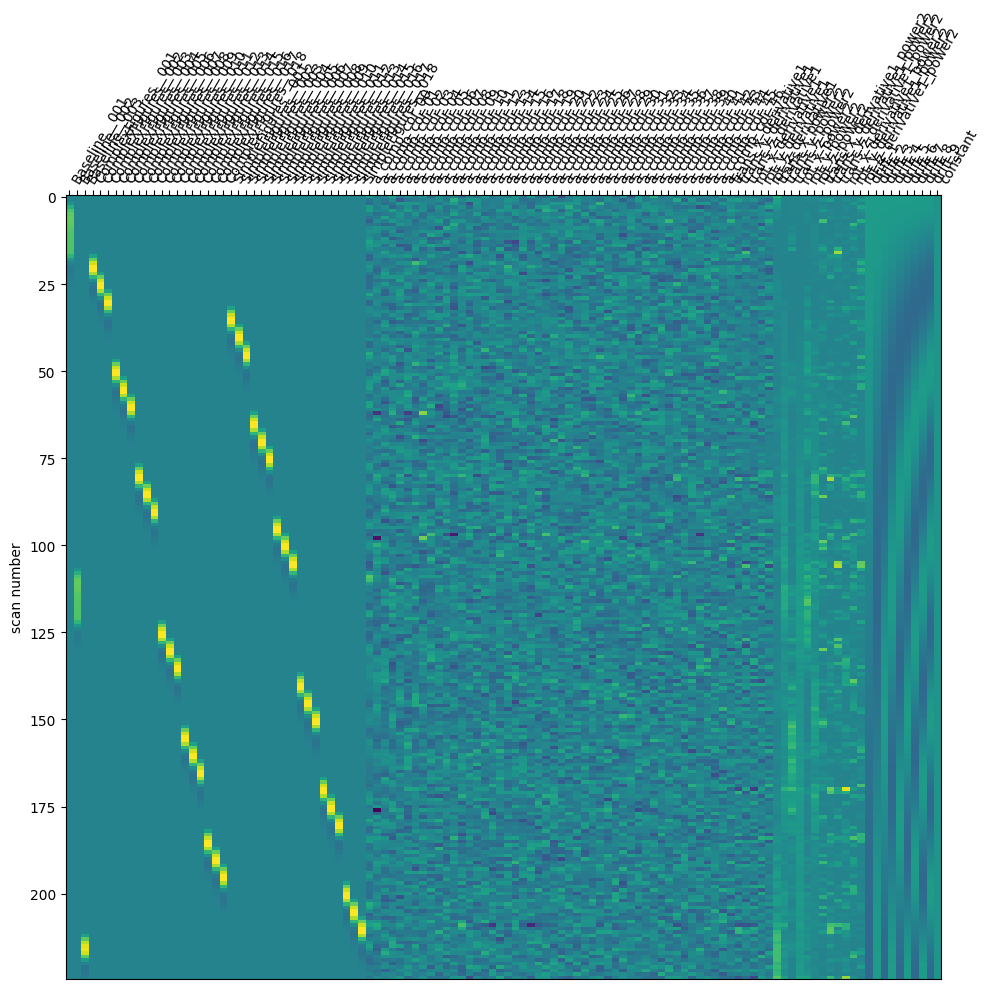

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plotting.plot_design_matrix(glm.design_matrices_[0], ax=ax)
fig.show()

In [9]:
beta_maps = {cond: [] for cond in events_df["trial_type"].unique()}
trialwise_conditions = glm_events_df["trial_type"].unique()
for condition in trialwise_conditions:
    beta_map = glm.compute_contrast(condition, output_type="effect_size")
    # Drop the trial number from the condition name to get the original name
    condition_name = condition.split("__")[0]
    beta_maps[condition_name].append(beta_map)

In [10]:
fmri_image = img.concat_imgs((beta_maps['Baseline'], beta_maps['ComplexFigures'], beta_maps['SimpleFigures']))
condition_df = events_df.sort_values('trial_type') # to match the fmri image
condition_df['chunks'] = condition_df['trial_type'].apply(lambda trial: 2 if 'ComplexFigures' in trial else (1 if 'SimpleFigures' in trial else 0))
condition_mask = condition_df['trial_type'].isin(['SimpleFigures', 'ComplexFigures'])

In [11]:
fmri_img_index = img.index_img(fmri_image, condition_mask)

In [12]:
y_values = condition_df[condition_mask]['trial_type']
session = condition_df[condition_mask]['chunks']

In [13]:
mask_img = img.load_img(os.path.join(base_dir, 
                                     subject, 
                                     'func', 
                                     f'{subject}_task-eft_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz')
                                     )

In [14]:
from sklearn.model_selection import KFold
import nilearn.decoding

In [18]:
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    radius=2,
    n_jobs=1,
    verbose=5,
    cv=KFold(n_splits=4)
)

In [19]:
searchlight.fit(fmri_img_index, y_values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 39.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 39.2min finished


SearchLight(cv=KFold(n_splits=4, random_state=None, shuffle=False),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x7faf98767280>,
            radius=2, verbose=5)

In [21]:
from nilearn.maskers import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(
    mask_img=mask_img,
    runs=session,
    standardize="zscore",
    memory="nilearn_cache",
    memory_level=1,
)
fmri_masked = nifti_masker.fit_transform(fmri_img_index)

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:570: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  data = self._cache(


In [23]:
from sklearn.feature_selection import f_classif
import numpy as np

_, p_values = f_classif(fmri_masked, y_values)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = img.get_data(nifti_masker.inverse_transform(p_values))

/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [     2      3      4 ... 234378 234379 234380] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/k1812017/envs/neuroimaging/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [31]:
len(p_unmasked[p_unmasked > 0])

183407

In [24]:
mean_fmri = img.mean_img(fmri_img_index)

from nilearn.plotting import plot_img, plot_stat_map, show

searchlight_img = img.new_img_like(mean_fmri, searchlight.scores_)

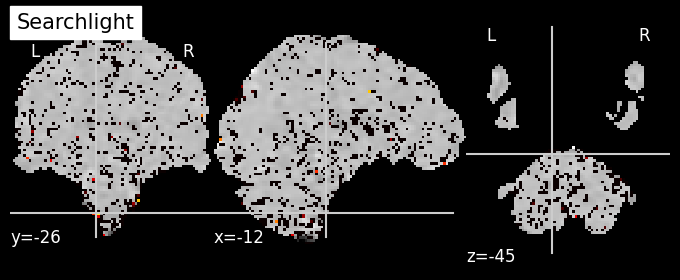

In [26]:
# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(
    searchlight_img,
    bg_img=mean_fmri,
    title="Searchlight",
    vmin=0.42,
    cmap="hot",
    threshold=0.2,
    black_bg=True,
)

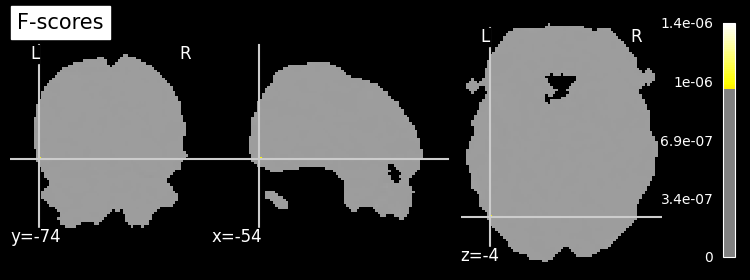

In [29]:
# F_score results
f_score_img = img.new_img_like(mean_fmri, p_unmasked)
plot_stat_map(
    f_score_img,
    mean_fmri,
    title="F-scores",
    colorbar=True,
    black_bg=True,
)